# Proyecto Integrador IV
> E-Commerce Data Pipeline

En este notebook, primero ejecutaremos todos los componentes de nuestro pipeline ELT y luego realizaremos visualizaciones con la información resultante


In [1]:
# Importing the necessary libraries
from pandas import DataFrame
from sqlalchemy import create_engine
from typing import Dict
from pathlib import Path

from src.transform import QueryEnum
from src import config
from src.transform import run_queries
from src.extract import extract
from src.load import load
from src.plots import (
    plot_freight_value_weight_relationship,
    plot_global_amount_order_status,
    plot_real_vs_predicted_delivered_time,
    plot_revenue_by_month_year,
    plot_revenue_per_state,
    plot_top_10_least_revenue_categories,
    plot_top_10_revenue_categories,
    plot_top_10_revenue_categories_ammount,
    plot_delivery_date_difference,
    plot_order_amount_per_day_with_holidays,
)

In [2]:
# Create the database sql file
Path(config.SQLITE_BD_ABSOLUTE_PATH).touch()

# Create the database connection
ENGINE = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

### 1. Extract

Aquí estarás extrayendo la información de las fuentes.

In [3]:
config.get_csv_to_table_mapping()

{'olist_customers_dataset.csv': 'olist_customers',
 'olist_geolocation_dataset.csv': 'olist_geolocation',
 'olist_order_items_dataset.csv': 'olist_order_items',
 'olist_order_payments_dataset.csv': 'olist_order_payments',
 'olist_order_reviews_dataset.csv': 'olist_order_reviews',
 'olist_orders_dataset.csv': 'olist_orders',
 'olist_products_dataset.csv': 'olist_products',
 'olist_sellers_dataset.csv': 'olist_sellers',
 'product_category_name_translation.csv': 'product_category_name_translation'}

In [4]:
csv_folder = config.DATASET_ROOT_PATH
public_holidays_url = config.PUBLIC_HOLIDAYS_URL
years_query = config.YEARS_QUERY
code_country = config.CODE_COUNTRY

# 1. Get the mapping of the csv files to the table names.
csv_table_mapping = config.get_csv_to_table_mapping()

# 2. Extract the data from the csv files, holidays and load them into the dataframes.
csv_dataframes = extract(csv_folder, csv_table_mapping, public_holidays_url, years_query, code_country)

### 2. Load

Usando los diferentes conjuntos de datos proporcionados, almacenarás todo en nuestro Data Warehouse.

In [5]:
load(data_frames=csv_dataframes, database=ENGINE)

{'olist_customers': 'éxito',
 'olist_geolocation': 'éxito',
 'olist_order_items': 'éxito',
 'olist_order_payments': 'éxito',
 'olist_order_reviews': 'éxito',
 'olist_orders': 'éxito',
 'olist_products': 'éxito',
 'olist_sellers': 'éxito',
 'product_category_name_translation': 'éxito',
 'public_holidays': 'éxito'}

### 3. Transform

Aquí transformarás las diferentes consultas en tablas. Hay dos secciones: una con las consultas relacionadas con los ingresos y otra con las consultas relacionadas con las entregas.

##### 3.1 Queries sobre ingresos

In [6]:
query_results: Dict[str, DataFrame] = run_queries(database=ENGINE)

In [7]:
# Transforming the revenue_by_month_year query to a table
revenue_by_month_year = query_results[QueryEnum.REVENUE_BY_MONTH_YEAR.value]
revenue_by_month_year

,month_no,month,Year2016,Year2017,Year2018
0,01,Jan,0.00,37632.57,969967.80
1,02,Feb,0.00,93294.52,1014670.33
2,03,Mar,0.00,146225.87,1178194.86
3,04,Apr,0.00,186789.68,2902282.37
4,05,May,0.00,296714.63,1117586.66
5,06,Jun,0.00,489463.42,1141543.85
6,07,Jul,0.00,599381.69,1004633.26
7,08,Aug,0.00,627388.11,889322.54
8,09,Sep,0.00,632850.42,53088.57
9,10,Oct,0.00,694981.11,0.00


In [8]:
# Transforming the top_10_revenue_categories query to a table
top_10_revenue_categories = query_results[QueryEnum.TOP_10_REVENUE_CATEGORIES.value]
top_10_revenue_categories

,Category,Num_order,Revenue
0,bed_bath_table,6876,945494.47
1,health_beauty,10778,850301.85
2,sports_leisure,4301,761306.16
3,furniture_decor,6336,745120.99
4,computers_accessories,3765,642888.40
5,housewares,4285,606491.68
6,watches_gifts,2233,227660.65
7,telephony,2170,201938.83
8,garden_tools,1518,198310.43
9,auto,1512,196005.11


In [9]:
# Transforming the top_10_least_revenue_categories query to a table
top_10_least_revenue_categories = query_results[
    QueryEnum.TOP_10_LEAST_REVENUE_CATEGORIES.value
]
top_10_least_revenue_categories

,Category,Num_order,Revenue
0,security_and_services,2,394.80
1,cds_dvds_musicals,10,1246.62
2,la_cuisine,38,3301.12
3,home_comfort_2,1,10.00
4,flowers,45,3856.59
5,arts_and_craftmanship,78,10294.65
6,fashion_sport,87,11983.94
7,christmas_supplies,94,13452.49
8,baby,176,17856.92
9,fashion_childrens_clothes,73,8907.58


In [12]:
# Transforming the revenue_per_state query to a table
revenue_per_state = query_results[QueryEnum.REVENUE_PER_STATE.value]
revenue_per_state

,customer_state,Revenue
0,SP,5769081.27
1,RJ,2055690.45
2,MG,1819277.61
3,RS,861608.40
4,PR,781919.55
5,SC,595208.40
6,BA,591270.60
7,DF,346146.17
8,GO,334294.22
9,ES,317682.65


##### 3.2 Queries sobre entregas

In [13]:
# Transforming the delivery_date_difference query to a table
delivery_date_difference = query_results[QueryEnum.DELIVERY_DATE_DIFFERECE.value]
delivery_date_difference

,State,Delivery_Difference
0,AL,8
1,MA,9
2,BA,10
3,CE,10
4,ES,10
5,SE,10
6,MS,11
7,PI,11
8,RJ,11
9,SC,11


In [14]:
# Transforming the real vs predicted delivered time query to a table per month and year
real_vs_estimated_delivered_time = query_results[
    QueryEnum.REAL_VS_ESTIMATED_DELIVERED_TIME.value
]
real_vs_estimated_delivered_time

,month_no,month,Year2016_real_time,Year2017_real_time,Year2018_real_time,Year2016_estimated_time,Year2017_estimated_time,Year2018_estimated_time
0,01,Jan,NaN,12.65,14.08,NaN,39.51,26.30
1,02,Feb,NaN,13.17,16.95,NaN,31.85,24.53
2,03,Mar,NaN,12.95,16.30,NaN,24.73,22.03
3,04,Apr,NaN,14.92,11.50,NaN,27.35,23.68
4,05,May,NaN,11.32,11.42,NaN,24.28,22.89
5,06,Jun,NaN,12.01,9.24,NaN,24.02,27.77
6,07,Jul,NaN,11.59,8.96,NaN,23.32,19.69
7,08,Aug,NaN,11.15,7.73,NaN,23.48,15.19
8,09,Sep,54.81,11.85,NaN,18.49,22.44,NaN
9,10,Oct,19.60,11.86,NaN,55.68,23.02,NaN


In [15]:
# Transforming the global ammount of order status query to a table
global_ammount_order_status = query_results[QueryEnum.GLOBAL_AMMOUNT_ORDER_STATUS.value]
global_ammount_order_status

,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [8]:
orders_per_day_and_holidays = query_results[
    QueryEnum.ORDERS_PER_DAY_AND_HOLIDAYS_2017.value
]
orders_per_day_and_holidays

,date,order_count,holiday
0,2017-01-05,32,False
1,2017-01-06,4,False
2,2017-01-07,4,False
3,2017-01-08,6,False
4,2017-01-09,5,False
...,...,...,...
356,2017-12-27,167,False
357,2017-12-28,146,False
358,2017-12-29,135,False
359,2017-12-30,97,False


In [8]:
freight_value_weight_relationship = query_results[
    QueryEnum.GET_FREIGHT_VALUE_WEIGHT_RELATIONSHIP.value
]

freight_value_weight_relationship

,order_id,freight_value,product_weight_g
0,00010242fe8c5a6d1ba2dd792cb16214,13.29,650.0
1,00018f77f2f0320c557190d7a144bdd3,19.93,30000.0
2,000229ec398224ef6ca0657da4fc703e,17.87,3050.0
3,00024acbcdf0a6daa1e931b038114c75,12.79,200.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,18.14,3750.0
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,43.41,10150.0
96474,fffcd46ef2263f404302a634eb57f7eb,36.53,8950.0
96475,fffce4705a9662cd70adb13d4a31832d,16.95,967.0
96476,fffe18544ffabc95dfada21779c9644f,8.72,100.0


### 4. Graficas de las tablas resultantes

Ahora, crearemos gráficos a partir de las diferentes consultas.

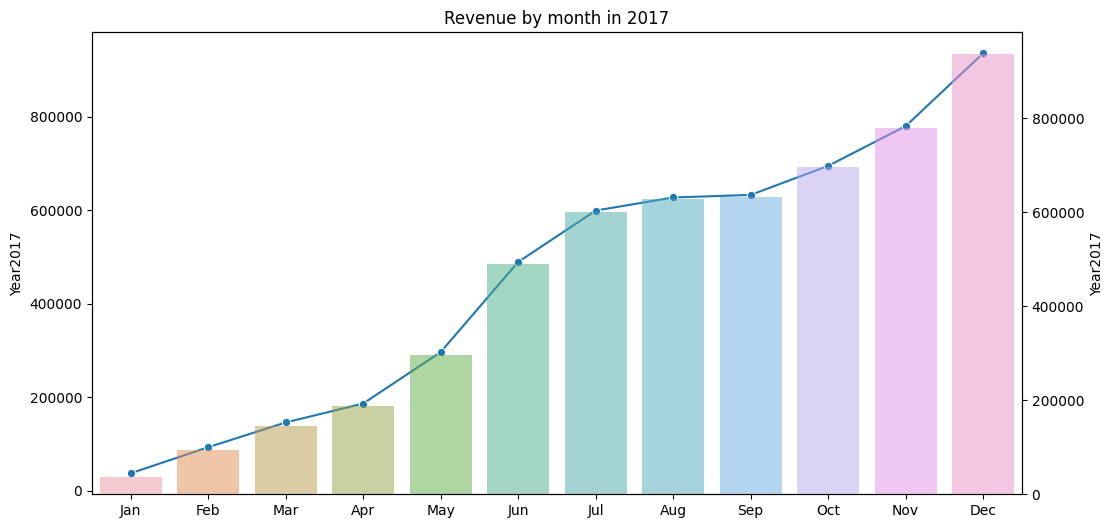

In [18]:
plot_revenue_by_month_year(revenue_by_month_year, 2017)

In [19]:
plot_top_10_revenue_categories(top_10_revenue_categories)

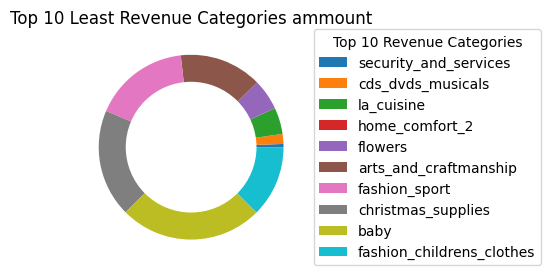

In [20]:
plot_top_10_least_revenue_categories(top_10_least_revenue_categories)

In [21]:
plot_revenue_per_state(revenue_per_state)

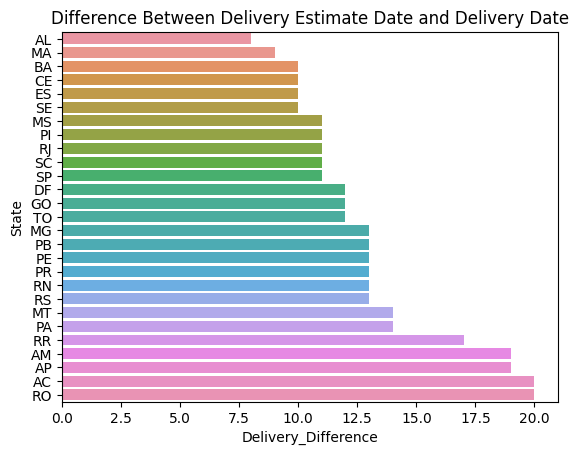

In [22]:
plot_delivery_date_difference(delivery_date_difference)

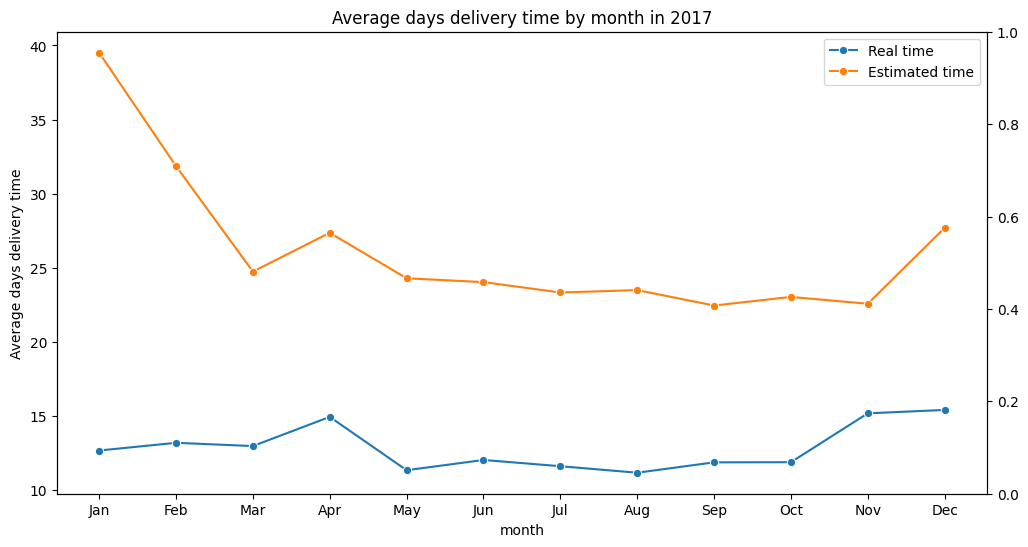

In [23]:
plot_real_vs_predicted_delivered_time(real_vs_estimated_delivered_time, year=2017)

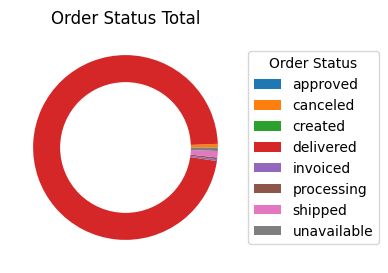

In [24]:
plot_global_amount_order_status(global_ammount_order_status)

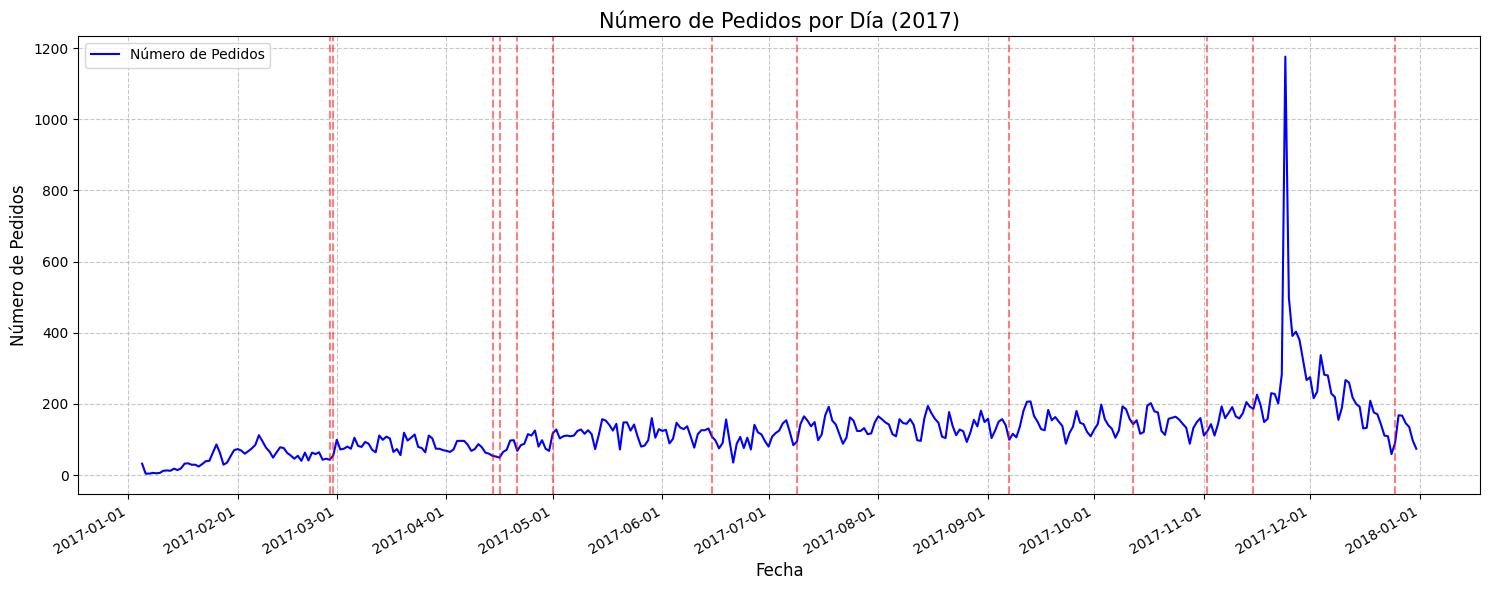

In [9]:
plot_order_amount_per_day_with_holidays(orders_per_day_and_holidays)

El gráfico de Pedidos por Día y Días Festivos que programarás en **src/plots.py** debe ser similar a este:

![The plot you will code will be similar to this:](images/orders_per_day_and_holidays.png "Orders per Day and Holidays")

4.1 ¿Ves alguna relación entre los días festivos en Brasil durante 2017 y las compras de ese año?

Respuesta: No se ve correlación entre las fechas fechas festivos con el número de compras.

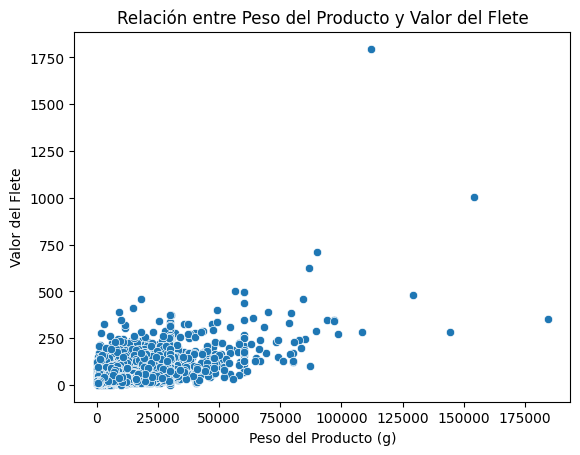

In [9]:
plot_freight_value_weight_relationship(freight_value_weight_relationship)

El gráfico sobre la relación entre el valor del flete y el peso del producto que debes programar en `src/plots.py` tiene que ser similar a este:

![The plot you will code will be similar to this:](images/freight_value_weight_relationship.png "Freight Value and Weight Relationship")

4.2 ¿Ves alguna correlación entre el valor del flete y el peso del producto?

Respuesta: Parece que la mayor parte de las veces, entre menor es el peso del producto, menor es el peso del flete. Aunque existen excepciones como los outliers que se alcanzan a ver, como que aunque el peso es menor es igual a otros productos, su flete tiene un mayor valor, posiblemente es mercancía más delicada que requiere un mayor cuidado al transportarse.